In [1]:
# Import libraries and needed classes

import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from Code.utils.dataset import Dataset
import Code.utils.store_model as store_model

In [2]:
# Set random seed to control randomness

np.random.seed(42)
tf.random.set_seed(42)


In [3]:
# Read datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                      '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                      '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                      '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                      '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                      '../../Dataset/DatasetsGerados/dataset_test_output.csv')

X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets('Text', 'Label', sep='\t', rem_punctuation=False)

In [4]:
# Build network
timestep = 2

X_train = X_train.reshape((X_train.shape[0], timestep, X_train.shape[1] // timestep))
X_validation = X_validation.reshape((X_validation.shape[0], timestep, X_validation.shape[1] // timestep))
X_test = X_test.reshape((X_test.shape[0], timestep, X_test.shape[1] // timestep))

batch_size = 8

# define model
model = Sequential([
    Input(shape=(timestep, X_train.shape[2])),
    SimpleRNN(5, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

#compilar modelo
optimizer = SGD(learning_rate=0.005, momentum=0.90)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001, restore_best_weights=True)

Epoch 1/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7718 - loss: 0.5147 - val_accuracy: 0.9280 - val_loss: 0.3208
Epoch 2/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9459 - loss: 0.2098 - val_accuracy: 0.9590 - val_loss: 0.1885
Epoch 3/3
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9700 - loss: 0.1273 - val_accuracy: 0.9580 - val_loss: 0.1542


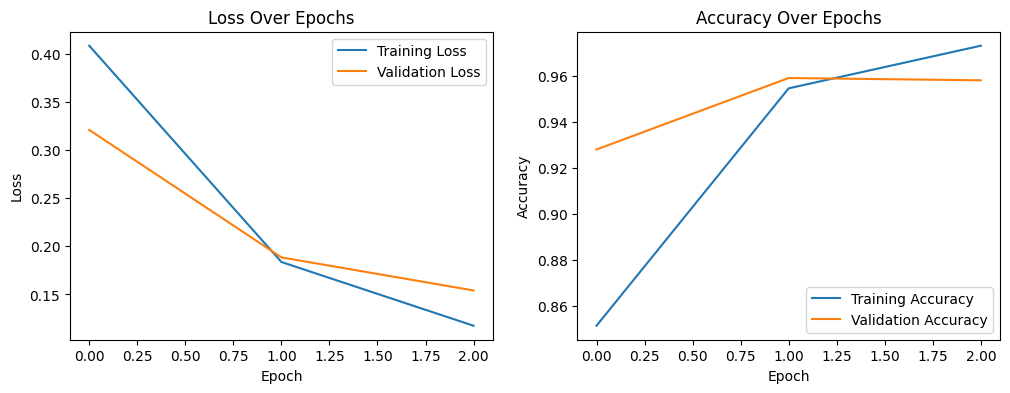

In [5]:
# Train network
history = model.fit(X_train, y_train,
                    validation_data=(X_validation, y_validation),
                    epochs=3,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1)

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
# Test network
out = model.predict(X_test)
out = out.reshape(out.shape[0], 1)


if y_test is not None:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

if y_validation is not None:
    loss, accuracy = model.evaluate(X_validation, y_validation, verbose=0)
    print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test Loss: 0.1503015160560608, Test Accuracy: 0.9589999914169312
Validation Loss: 0.15418261289596558, Validation Accuracy: 0.9580000042915344


In [7]:
# Store results
store_results = './Results/rnn_results.csv'
os.makedirs(os.path.dirname(store_results), exist_ok=True)
results = dataset.merge_results(ids, out)
results.to_csv(store_results, sep='\t', index=False)

os.makedirs(os.path.dirname(store_results), exist_ok=True)

results = dataset.merge_results(ids, out)
results.to_csv(store_results, sep='\t', index=False)

In [8]:
# Store network model

model_filepath = './Model/rnn'
model_key = 'rnn'

store_model.store_model(model_filepath, model_key, model)

In [9]:
# Retrieve network model

model_filepath = './Model/rnn'
model_key = 'rnn'

model = store_model.retrieve_model(model_filepath, model_key)